In [1]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

from brian2 import prefs


prefs.codegen.target = 'cython'




# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 100   # Initial synaptic weight (conductance)

regularizer = 1 * nS


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : 1   # Synaptic weight, conductance

Iexc_post = w * X * amp : amp (summed)
'''

syn_eqs_exc_2 = '''
w : 1   # Synaptic weight, conductance

Iexc_2_post = w * X * amp : amp (summed)
'''

syn_eqs_exc_3 = '''
w : 1

Iexc_3_post = w * X * amp : amp (summed)
'''

syn_eqs_exc_4 = '''
w : 1

Iexc_4_post = w * X * amp : amp (summed)
'''


syn_eqs_exc_output = '''
w : 1   # Synaptic weight, conductance

Iexc_internal_post = w * X * amp  : amp (summed)
'''



syn_eqs_inh= '''
w : 1   # Synaptic weight, conductance

Iinh_post = w * X * amp  : amp (summed)
'''

syn_eqs_inh_2= '''
w : 1   # Synaptic weight, conductance

Iinh_2_post = w * X * amp  : amp (summed)
'''

syn_eqs_inh_3= '''
w : 1   # Synaptic weight, conductance

Iinh_3_post = w * X * amp  : amp (summed)
'''

syn_eqs_inh_4= '''
w : 1   # Synaptic weight, conductance

Iinh_4_post = w * X * amp  : amp (summed)
'''



def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for ii, dim in enumerate(dims):
        if ii == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [ii for ii in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            

def make_bottom_up_connections(R, E_0, E_1):
    print("A")
    print("Bottom-up: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s1")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1', custom_name = "s2")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m

def make_bottom_up_connections_2(E_0, E_1,R):
    print("B")
    print("Bottom-up-2: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(E_0, R, model=syn_eqs_exc_2, on_pre='Y_post = 1', custom_name = "s3")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(E_1, R,  model=syn_eqs_inh_2, on_pre='Y_post = 1', custom_name = "s4")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    print("C")
    print("Top-down: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_1, model=syn_eqs_exc_3, on_pre='Y_post = 1', custom_name = "s5")
    #S_p.connect()
    manual_fully_connect(S_p, R.N, E_1.N)
    S_p.w = 'rand() * w_init'

    S_m = NamedSynapses(R, E_0, model=syn_eqs_inh_3, on_pre='Y_post = 1', custom_name = "s6")
    S_m.connect()
    manual_fully_connect(S_m, R.N, E_0.N)
    S_m.w = 'rand() * w_init'

    return S_p, S_m



def make_top_down_connections_2(E_0, E_1, R):
    print("D")
    print("Top-down-2: ", R.N, E_0.N, E_1.N )
    S_p_2 = NamedSynapses(E_1, R,  model=syn_eqs_exc_4, on_pre='Y_post = 1', custom_name = "s7")
    #S_p.connect()
    manual_fully_connect(S_p_2, E_1.N, R.N)
    S_p_2.w = 'rand() * w_init'

    S_m_2 = NamedSynapses(E_0, R,  model=syn_eqs_inh_4, on_pre='Y_post = 1', custom_name = "s8")
    #S_m.connect()
    manual_fully_connect(S_m_2, E_0.N, R.N)
    S_m_2.w = 'rand() * w_init'

    return S_p_2, S_m_2



def make_gist_connections(Rs, G):
    S_gist_input = NamedSynapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s9")
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = NamedSynapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s10")
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output



def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/3000

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #S_o = NamedSynapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        #S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for ii in range(max_depth):
        for _ in range(num_classes_per_layer**(ii+1)):
            stimulus_indices.append(ii)
    Os.indices = stimulus_indices

    return Os#, S_o






def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)
    Os = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for ii in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[ii], Es_0[ii], Es_1[ii])

        if ii != 0:
            S_p_2, S_m_2 = make_bottom_up_connections_2(Es_0[ii], Es_1[ii], Rs[ii])
            connections[f"bottom_up_2_{ii}"] = [S_p_2, S_m_2]
        connections[f"bottom_up_{ii}"] = [S_p, S_m]

        if ii != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[ii+1], Es_0[ii], Es_1[ii])
            S_p_td_2, S_m_td_2 = make_top_down_connections_2(Es_0[ii], Es_1[ii], Rs[ii+1])
            connections[f"top_down_{ii}"] = [S_p_td, S_m_td]
            connections[f"top_down_2_{ii}"] = [S_p_td_2, S_m_td_2]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = NamedSynapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s11")
    S_o_external_2 = NamedSynapses(Os, Rs[-1],  model=syn_eqs_exc_2, on_pre='Y_post = 1', custom_name = "s12")
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]
    connections["output_external_2"] = [S_o_external_2]

  
    # return Rs, Es_0, Es_1, G, Os, S_o_internal, connections
    
    return Rs, Es_0, Es_1, G, Os,  connections




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for ii in range(labels.shape[1]):
        summed = 0
        if ii > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(ii-j) for j in range(ii)]).sum(dim=0)
        indexes[:, ii] = summed + labels[:, ii]

    # Adjust indexes for concatenation
    to_sum = 0
    for ii in range(labels.shape[1]):
        if ii > 0:
            to_sum += num_classes_per_layer**ii
        indexes[:, ii] = indexes[:, ii] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [5, 4, 3, 2]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs, Es_0, Es_1, G, Os, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 100
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")




@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])
    
    

@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X
            


def if_positive(x, w):
    if w>0:
        return x 
    else:
        return 0 * siemens
    
    
@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        S_p_2, S_m_2 = connections[f"top_down_2_{n}"]
        
        
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                positive_connections_delta = asarray(lr * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx]) - asarray(if_positive(regularizer, S_p.w[i_idx, j_idx]))
                negative_connections_delta = asarray(lr * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx]) - asarray(if_positive(regularizer, S_m.w[i_idx, j_idx]))
                
                S_p.w[i_idx, j_idx] += positive_connections_delta
                S_m.w[i_idx, j_idx] -= negative_connections_delta
                
                S_p_2.w[i_idx, j_idx] += positive_connections_delta
                S_m_2.w[i_idx, j_idx] -= negative_connections_delta
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0
    
    
    
    external_syn = connections["output_external"][0]
    external_syn_2 = connections["output_external_2"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            delta = lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            external_syn.w[i_idx, j_idx] += delta
            external_syn_2.w[i_idx, j_idx] += delta
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
        
            
            


# Extract all synapses and objects for the network
all_synapses = []
# all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

for i in range(1,len(Rs)-1):
    bu_syns = connections[f"bottom_up_2_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_2_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
external_syn_2 = connections["output_external_2"][0]
all_synapses.append(external_syn)

#monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
#spike_monitor = SpikeMonitor(Rs[0])

s = 0

        


monitor_o = StateMonitor(Os, ['v', 'I_tot', 'X'], record=True)
spike_mon_o = NamedSpikeMonitor(Os, record = True, custom_name = "output")

'''
net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,        
    monitor_o, spike_mon_o,         # <-- Add these
    debug, update_sums, apply_weight_update
)
'''

# Add spike monitors for all neuron groups

spike_mon_G = NamedSpikeMonitor(G, record=True, custom_name = "Gist")


# Add all monitors to the network
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups       
    monitor_o, spike_mon_o, # Output monitors
    spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update  # Additional operations
)

for i in range(len(Rs)):
    net.add(NamedSpikeMonitor(Rs[i], record=True, custom_name = f"R[{i}]"))
    if i > 0:
        net.add(NamedSpikeMonitor(Es_0[i-1], record=True, custom_name = f"Es_0[{i-1}]"))
        net.add(NamedSpikeMonitor(Es_1[i-1], record=True, custom_name = f"Es_1[{i-1}]"))

for synapse in all_synapses:
    net.add(synapse)

A
Bottom-up:  5 5 5
synapses s1
synapses_1 s2
C
Top-down:  4 5 5
synapses_2 s5
synapses_3 s6
D
Top-down-2:  4 5 5
synapses_4 s7
synapses_5 s8
A
Bottom-up:  4 4 4
synapses_6 s1
synapses_7 s2
B
Bottom-up-2:  4 4 4
synapses_8 s3
synapses_9 s4
C
Top-down:  3 4 4
synapses_10 s5
synapses_11 s6
D
Top-down-2:  3 4 4
synapses_12 s7
synapses_13 s8
A
Bottom-up:  3 3 3
synapses_14 s1
synapses_15 s2
B
Bottom-up-2:  3 3 3
synapses_16 s3
synapses_17 s4
C
Top-down:  2 3 3
synapses_18 s5
synapses_19 s6
D
Top-down-2:  2 3 3
synapses_20 s7
synapses_21 s8
synapses_22 s9
synapses_23 s10
synapses_24 s11
synapses_25 s12


In [ ]:
num_epochs = 3

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms

for i in range(num_epochs):
    print(f"Starting epoch {i}.")
    start = time.time()
    
    stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))
    
    s = 0
    stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))
    net.stimulus_indexes = stimulus_indexes
    net.output_stimuli   = output_stimuli
    net.input_stimuli    = input_stimuli
    
    net.run(run_time)
    
    duration = time.time() - start

    if i == 0:
        total_estimated_duration = duration * num_epochs
        estimated_finish = datetime.datetime.now() + datetime.timedelta(seconds=total_estimated_duration)
        print("Estimated finish time:", estimated_finish.strftime("%H:%M:%S"))


    print(f"Epoch {i} took {duration:.2f} seconds.\n")

Starting epoch 0.


In [4]:
net.objects

NameError: name 'net' is not defined

In [11]:
states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)


spikemonitor
spikemonitor_1
spikemonitor_10
spikemonitor_11
spikemonitor_2
spikemonitor_3
spikemonitor_4
spikemonitor_5
spikemonitor_6
spikemonitor_7
spikemonitor_8
spikemonitor_9


In [5]:


keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)


spikemonitor
spikemonitor_1
spikemonitor_10
spikemonitor_11
spikemonitor_2
spikemonitor_3
spikemonitor_4
spikemonitor_5
spikemonitor_6
spikemonitor_7
spikemonitor_8
spikemonitor_9


NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_11')


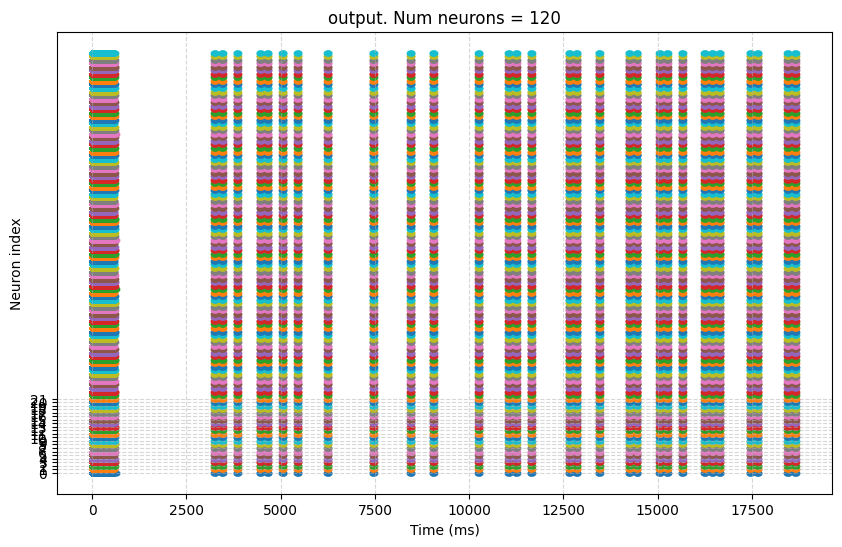

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_10')


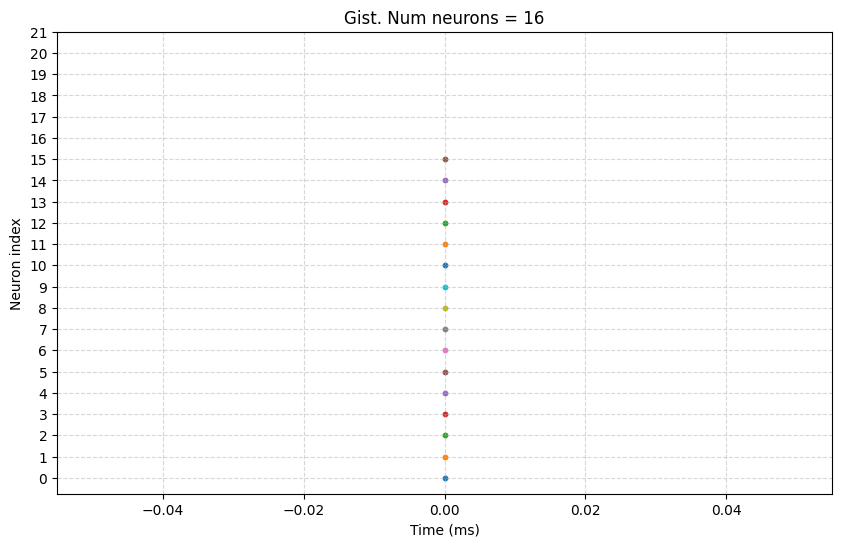

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_6')


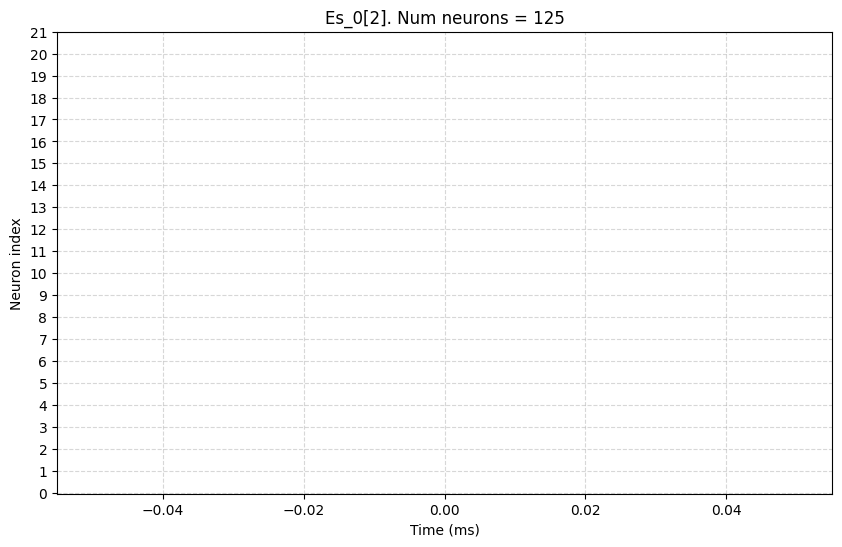

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_9')


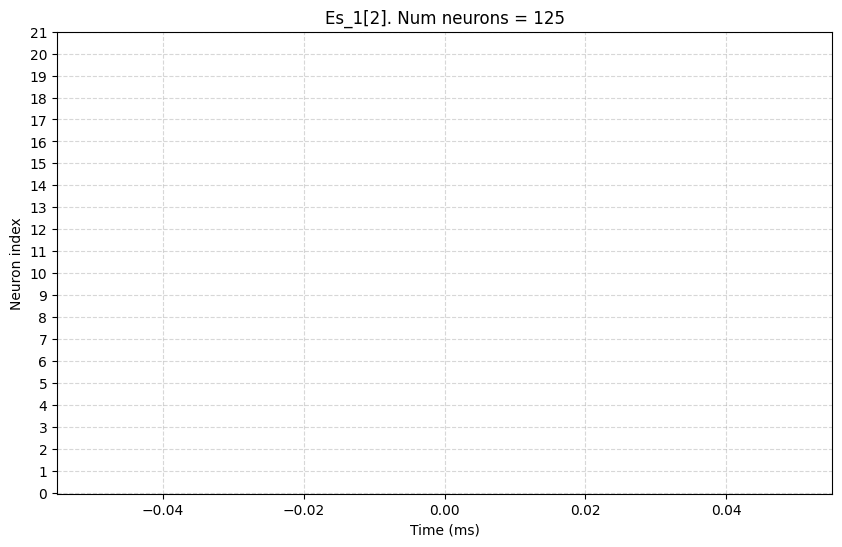

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


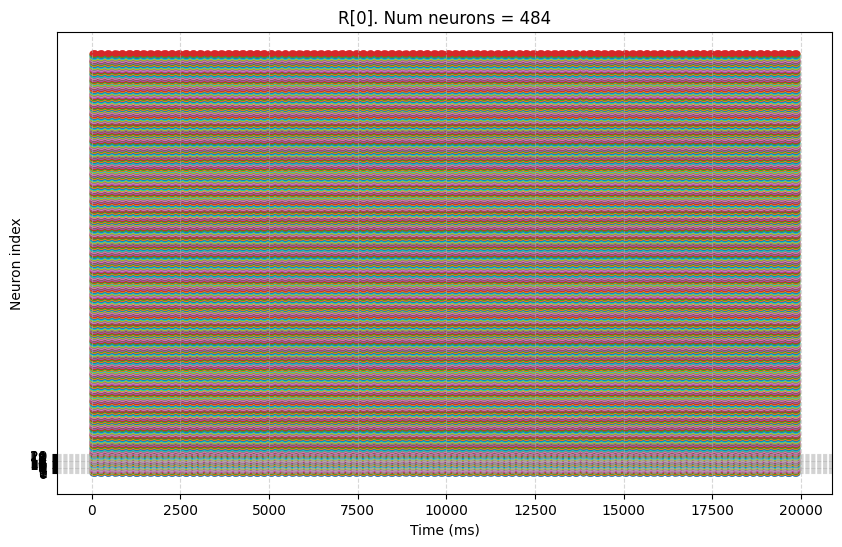

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


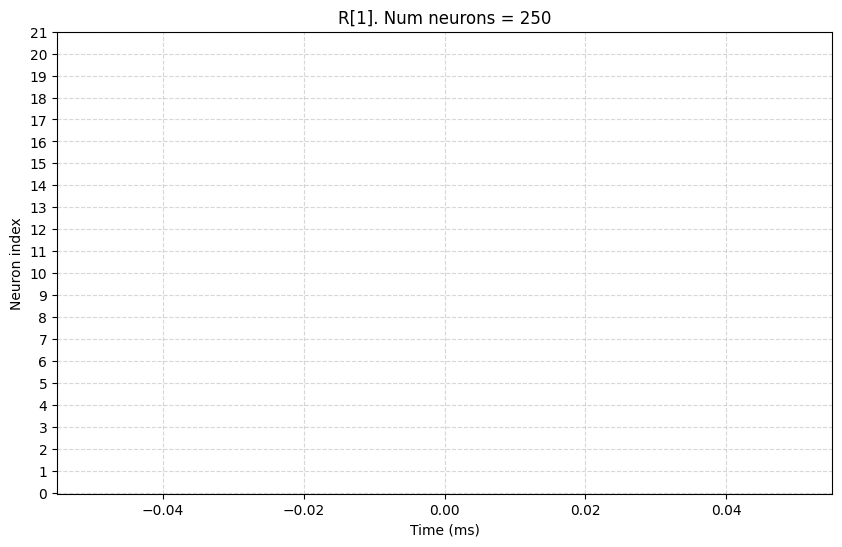

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')


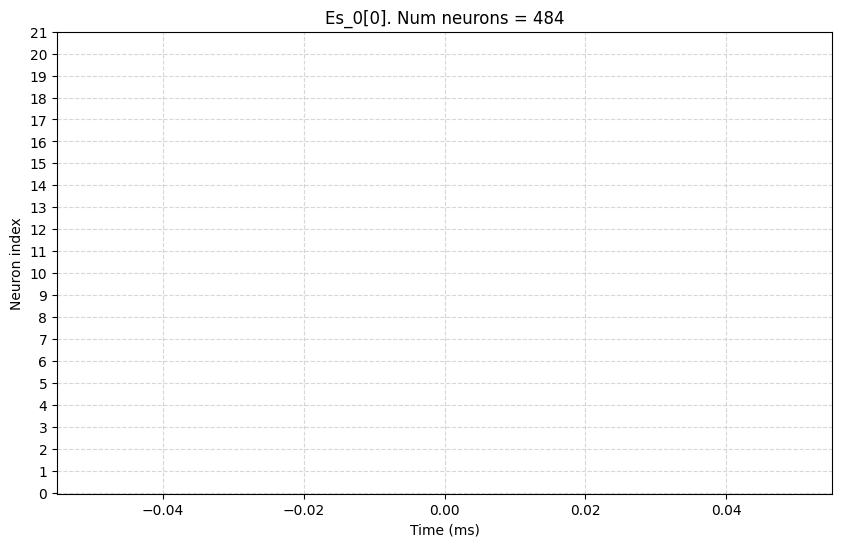

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_7')


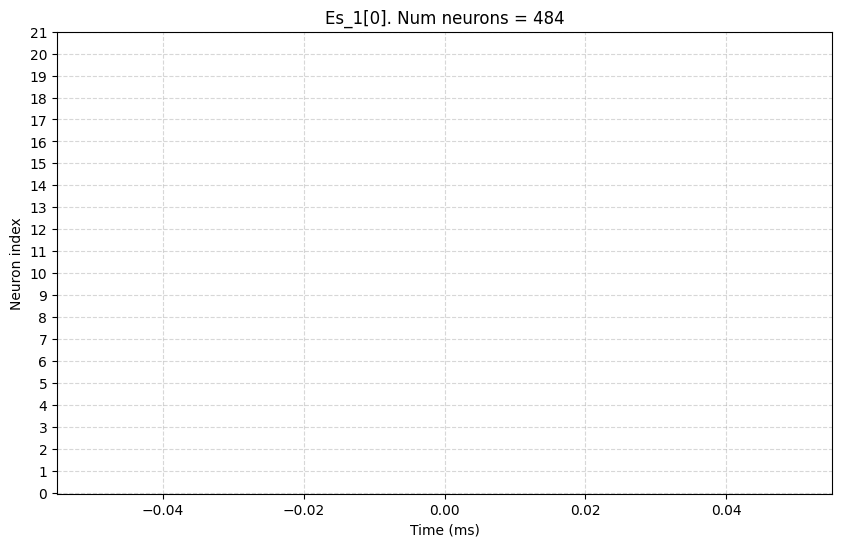

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')


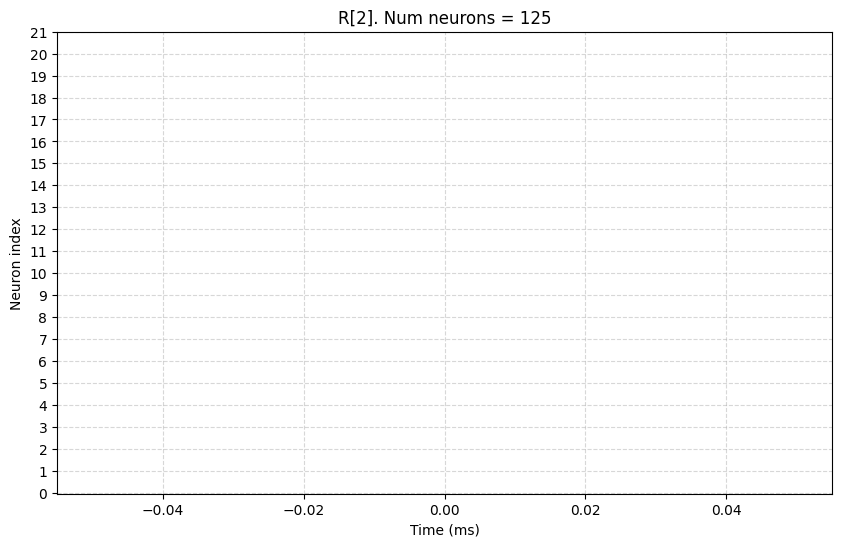

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_5')


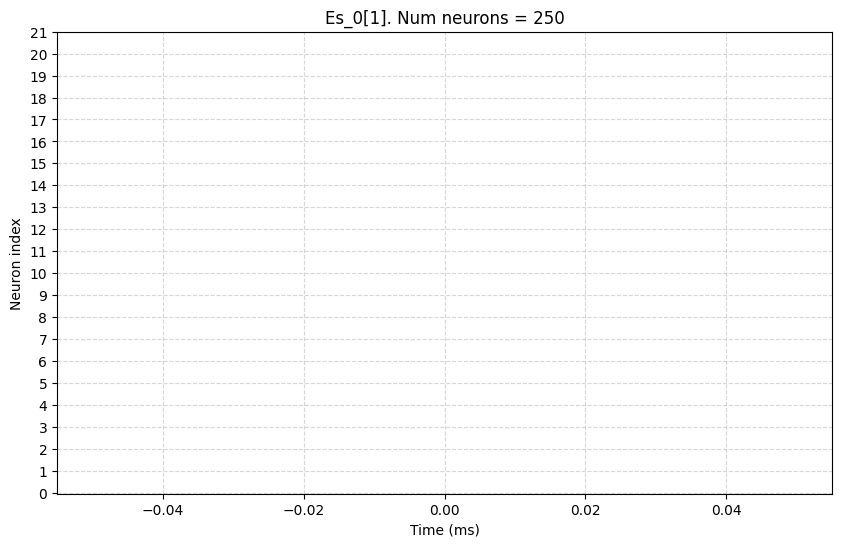

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_8')


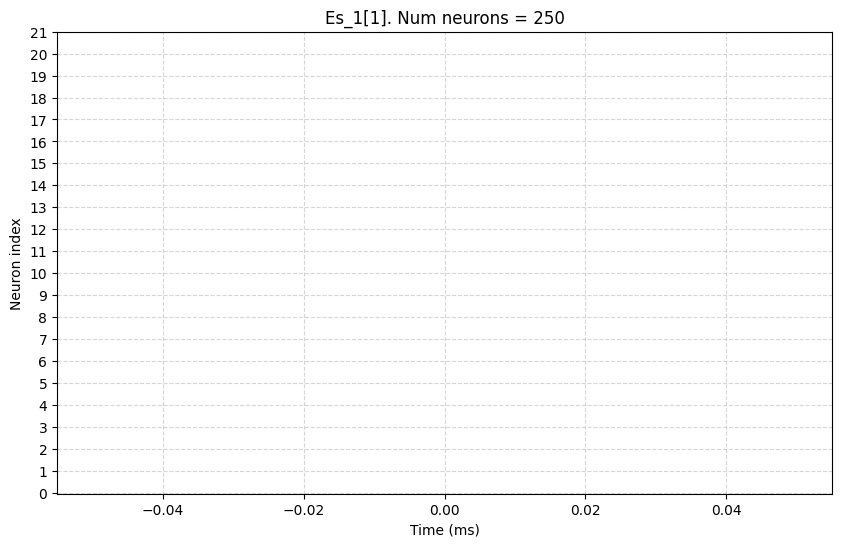

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


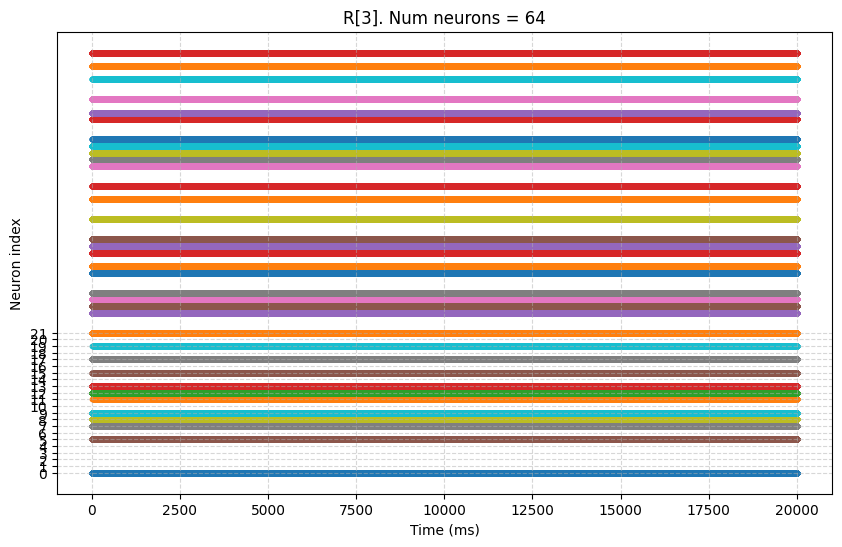

In [6]:
for spike_mon in spike_monitors:
    spikes = spike_mon.spike_trains()
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 1000:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
    '''# Add spike monitors for all neuron groups
spike_mon_Rs = [SpikeMonitor(group, record=True) for group in Rs]
spike_mon_Es_0 = [SpikeMonitor(group, record=True) for group in Es_0]
spike_mon_Es_1 = [SpikeMonitor(group, record=True) for group in Es_1]
spike_mon_G = SpikeMonitor(G, record=True)


# Add all monitors to the network
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups
    all_synapses,           # Synapses
    monitor_o, spike_mon_o, # Output monitors
    spike_mon_Rs, spike_mon_Es_0, spike_mon_Es_1, spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update  # Additional operations
)
'''

In [11]:
print("Mean weight of bottom_up_0:", np.mean(bu_syns[0].w[:]))


Mean weight of bottom_up_0: 1. nS


In [16]:
spikes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

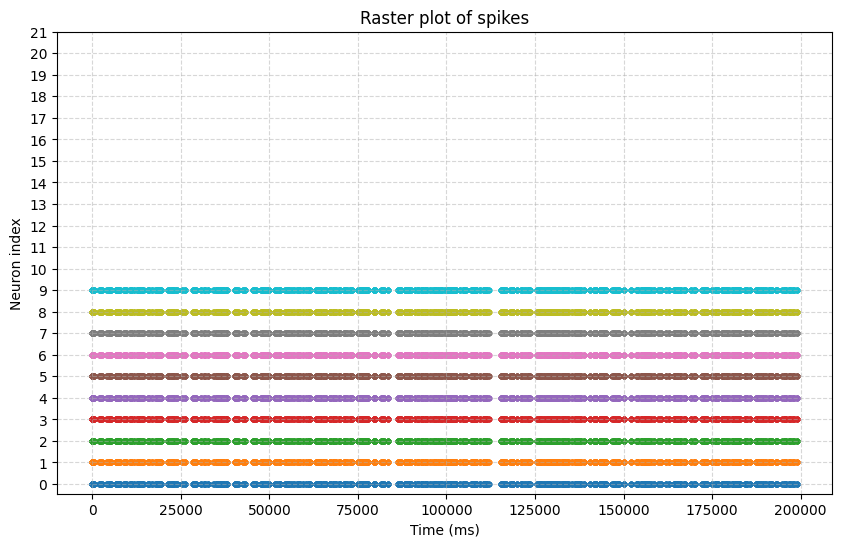

In [20]:
# Plotting the spike train with dots
plt.figure(figsize=(10, 6))
i=0
for neuron, spike_times in spikes.items():
    if i < 10:
        plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
        i+=1

plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of spikes')
plt.yticks(range(N))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Firing Rate')

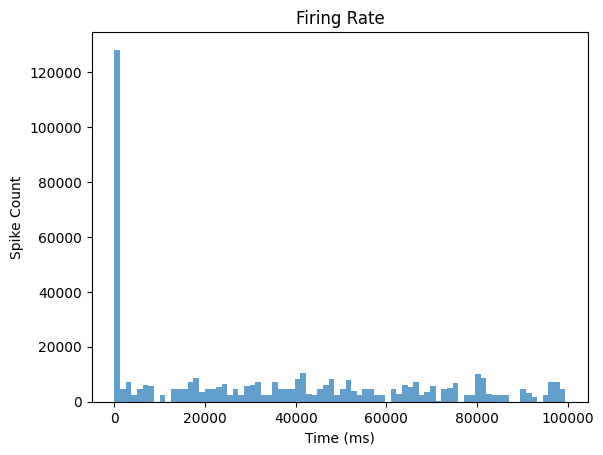

In [23]:
plt.hist(spike_mon_o["t"]/ ms, bins=80, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate')


In [24]:
from collections import defaultdict

# Organize spikes by neuron
spike_times_by_neuron = defaultdict(list)

# Loop through the recorded spikes
for neuron_idx, spike_time in zip(spike_mon_o["i"], spike_mon_o["t"]):
    spike_times_by_neuron[neuron_idx].append(spike_time)



In [9]:
for n in spike_times_by_neuron.keys():
    plt.hist(spike_times_by_neuron[n], bins=100, alpha=0.7)
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike Count')
    plt.title('Firing Rate')
    plt.show()

NameError: name 'spike_times_by_neuron' is not defined

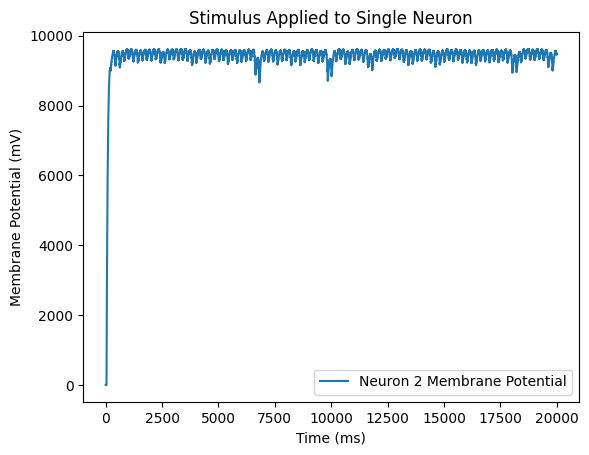

In [3]:
plt.plot(monitor_o.t / ms, monitor_o.X[1] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

In [5]:
spike_mon_o[7].t

TypeError: 'SpikeMonitor' object is not subscriptable

In [ ]:
# Suppose you want to plot the last batch's firing rates
all_batch_rates = [spike_monitor_os.count/run_time for spike_monitor_os in output_monitors]

for batch_rates in all_batch_rates:

  plt.figure(figsize=(10, 5))
  plt.bar(range(Os.N), batch_rates)
  plt.xlabel("Os Neuron Index")
  plt.ylabel("Firing rate (Hz)")
  plt.title("Average firing rate of Os neurons (last batch)")
  plt.show()


In [ ]:
# Chungus 

In [8]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

from brian2 import prefs


prefs.codegen.target = 'cython'




# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 100 * nS   # Initial synaptic weight (conductance)

regularizer = 1 * nS


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance

Iexc_post = w * X : amp (summed)
'''

syn_eqs_exc_2 = '''
w : siemens   # Synaptic weight, conductance

Iexc_2_post = w * X : amp (summed)
'''

syn_eqs_exc_3 = '''
w : siemens

Iexc_3_post = w * X : amp (summed)
'''

syn_eqs_exc_4 = '''
w : siemens

Iexc_4_post = w * X : amp (summed)
'''


syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance

Iexc_internal_post = w * X  : amp (summed)
'''



syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance

Iinh_post = w * X  : amp (summed)
'''

syn_eqs_inh_2= '''
w : siemens   # Synaptic weight, conductance

Iinh_2_post = w * X  : amp (summed)
'''

syn_eqs_inh_3= '''
w : siemens   # Synaptic weight, conductance

Iinh_3_post = w * X  : amp (summed)
'''

syn_eqs_inh_4= '''
w : siemens   # Synaptic weight, conductance

Iinh_4_post = w * X  : amp (summed)
'''



def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for ii, dim in enumerate(dims):
        if ii == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [ii for ii in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            

def make_bottom_up_connections(R, E_0, E_1):
    print("A")
    print("Bottom-up: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1*volt', custom_name = "s1")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1*volt', custom_name = "s2")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m

def make_bottom_up_connections_2(E_0, E_1,R):
    print("B")
    print("Bottom-up-2: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(E_0, R, model=syn_eqs_exc_2, on_pre='Y_post = 1*volt', custom_name = "s3")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(E_1, R,  model=syn_eqs_inh_2, on_pre='Y_post = 1*volt', custom_name = "s4")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    print("C")
    print("Top-down: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_1, model=syn_eqs_exc_3, on_pre='Y_post = 1*volt', custom_name = "s5")
    #S_p.connect()
    manual_fully_connect(S_p, R.N, E_1.N)
    S_p.w = 'rand() * w_init'

    S_m = NamedSynapses(R, E_0, model=syn_eqs_inh_3, on_pre='Y_post = 1*volt', custom_name = "s6")
    S_m.connect()
    manual_fully_connect(S_m, R.N, E_0.N)
    S_m.w = 'rand() * w_init'

    return S_p, S_m



def make_top_down_connections_2(E_0, E_1, R):
    print("D")
    print("Top-down-2: ", R.N, E_0.N, E_1.N )
    S_p_2 = NamedSynapses(E_1, R,  model=syn_eqs_exc_4, on_pre='Y_post = 1*volt', custom_name = "s7")
    #S_p.connect()
    manual_fully_connect(S_p_2, E_1.N, R.N)
    S_p_2.w = 'rand() * w_init'

    S_m_2 = NamedSynapses(E_0, R,  model=syn_eqs_inh_4, on_pre='Y_post = 1*volt', custom_name = "s8")
    #S_m.connect()
    manual_fully_connect(S_m_2, E_0.N, R.N)
    S_m_2.w = 'rand() * w_init'

    return S_p_2, S_m_2



def make_gist_connections(Rs, G):
    S_gist_input = NamedSynapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1*volt', custom_name = "s9")
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = NamedSynapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y_post = 1*volt', custom_name = "s10")
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output



def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/3000

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #S_o = NamedSynapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        #S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for ii in range(max_depth):
        for _ in range(num_classes_per_layer**(ii+1)):
            stimulus_indices.append(ii)
    Os.indices = stimulus_indices

    return Os#, S_o






def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)
    Os = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for ii in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[ii], Es_0[ii], Es_1[ii])

        if ii != 0:
            S_p_2, S_m_2 = make_bottom_up_connections_2(Es_0[ii], Es_1[ii], Rs[ii])
            connections[f"bottom_up_2_{ii}"] = [S_p_2, S_m_2]
        connections[f"bottom_up_{ii}"] = [S_p, S_m]

        if ii != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[ii+1], Es_0[ii], Es_1[ii])
            S_p_td_2, S_m_td_2 = make_top_down_connections_2(Es_0[ii], Es_1[ii], Rs[ii+1])
            connections[f"top_down{ii}"] = [S_p_td, S_m_td]
            connections[f"top_down_2_{ii}"] = [S_p_td_2, S_m_td_2]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = NamedSynapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1*volt', custom_name = "s11")
    S_o_external_2 = NamedSynapses(Os, Rs[-1],  model=syn_eqs_exc_2, on_pre='Y_post = 1*volt', custom_name = "s12")
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]
    connections["output_external_2"] = [S_o_external_2]

  
    # return Rs, Es_0, Es_1, G, Os, S_o_internal, connections
    
    return Rs, Es_0, Es_1, G, Os,  connections




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for ii in range(labels.shape[1]):
        summed = 0
        if ii > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(ii-j) for j in range(ii)]).sum(dim=0)
        indexes[:, ii] = summed + labels[:, ii]

    # Adjust indexes for concatenation
    to_sum = 0
    for ii in range(labels.shape[1]):
        if ii > 0:
            to_sum += num_classes_per_layer**ii
        indexes[:, ii] = indexes[:, ii] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [5, 4, 3, 2]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs, Es_0, Es_1, G, Os, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 100
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")




@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])
    
    

@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X
            


def if_positive(x, w):
    if w>0:
        return x
    else:
        return 0
    
    
@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        S_p_2, S_m_2 = connections[f"top_down_2_{n}"]
        
        
        
        
            
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                positive_connections_delta = lr * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens - if_positive(regularizer, S_p.w[i_idx, j_idx])
                negative_connections_delta = lr * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens - if_positive(regularizer, S_m.w[i_idx, j_idx])
                
                S_p.w[i_idx, j_idx] += positive_connections_delta
                S_m.w[i_idx, j_idx] -= negative_connections_delta
                
                S_p_2.w[i_idx, j_idx] += positive_connections_delta
                S_m_2.w[i_idx, j_idx] -= negative_connections_delta
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0
    
    
    
    external_syn = connections["output_external"][0]
    external_syn_2 = connections["output_external_2"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            delta = lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            external_syn.w[i_idx, j_idx] += delta
            external_syn_2.w[i_idx, j_idx] += delta
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
        
            
            
     
            




#monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
#spike_monitor = SpikeMonitor(Rs[0])

s = 0

        
        
monitor_o = StateMonitor(Os, ['v', 'I_tot'], record=True)
spike_mon_o = NamedSpikeMonitor(Os, record = True, custom_name = "output")

monitors = []
for ii in range(len(Rs)):
    monitors.append(NamedSpikeMonitor(Rs[ii], record=True, custom_name = f"R[{ii}]"))
    if ii > 0:
        monitors.append(NamedSpikeMonitor(Es_0[ii-1], record=True, custom_name = f"Es_0[{ii-1}]"))
        monitors.append(NamedSpikeMonitor(Es_1[ii-1], record=True, custom_name = f"Es_1[{ii-1}]"))
# Add spike monitors for all neuron groups

spike_mon_G = NamedSpikeMonitor(G, record=True, custom_name = "Gist")

spike_monitors = [ spike_mon_o, spike_mon_G]
for ii in range(len(Rs)):
    spike_monitors.append(NamedSpikeMonitor(Rs[ii], record=True, custom_name = f"R[{ii}]"))
    if ii > 0:
        spike_monitors.append(NamedSpikeMonitor(Es_0[ii-1], record=True, custom_name = f"Es_0[{ii-1}]"))
        spike_monitors.append(NamedSpikeMonitor(Es_1[ii-1], record=True, custom_name = f"Es_1[{ii-1}]"))


WARNING    'i' is an internal variable of group 'synapses_24', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


A
Bottom-up:  5 5 5
synapses_24 s1


WARNING    'i' is an internal variable of group 'synapses_25', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synapses_25 s2
C
Top-down:  4 5 5
synapses_58 s5
synapses_59 s6
D
Top-down-2:  4 5 5
synapses_60 s7
synapses_61 s8


WARNING    'i' is an internal variable of group 'synapses_62', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


A
Bottom-up:  4 4 4
synapses_62 s1


WARNING    'i' is an internal variable of group 'synapses_63', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synapses_63 s2


WARNING    'i' is an internal variable of group 'synapses_64', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


B
Bottom-up-2:  4 4 4
synapses_64 s3


WARNING    'i' is an internal variable of group 'synapses_65', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synapses_65 s4
C
Top-down:  3 4 4
synapses_66 s5
synapses_67 s6
D
Top-down-2:  3 4 4
synapses_68 s7
synapses_69 s8


WARNING    'i' is an internal variable of group 'synapses_70', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


A
Bottom-up:  3 3 3
synapses_70 s1


WARNING    'i' is an internal variable of group 'synapses_71', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synapses_71 s2


WARNING    'i' is an internal variable of group 'synapses_72', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


B
Bottom-up-2:  3 3 3
synapses_72 s3


WARNING    'i' is an internal variable of group 'synapses_73', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synapses_73 s4
C
Top-down:  2 3 3
synapses_74 s5
synapses_75 s6
D
Top-down-2:  2 3 3
synapses_76 s7
synapses_77 s8
synapses_78 s9
synapses_79 s10
synapses_80 s11
synapses_81 s12


WARNING    The object 'synapses_57' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_1262545/1741250523.py', line 200, in __init__
    super().__init__(source, target, model, **kwargs) [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_56' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_1262545/1741250523.py', line 200, in __init__
    super().__init__(source, target, model, **kwargs) [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Input')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Input')

plt.tight_layout()
plt.show()



## Other

In [ ]:
network = Network(
    *Rs,        # Unpack the list of NeuronGroups
    *Es_0,      # Unpack the list of NeuronGroups
    *Es_1,      # Unpack the list of NeuronGroups
    G,          # Single NeuronGroup is fine
    Os,         # Single NeuronGroup is fine
    connections["output_internal"],   # Single Synapses object is fine
    connections["gist_input"],        # Single Synapses object is fine
    *connections["gist_output"],      # Unpack the list of Synapses
    *connections["output_external"],  # Unpack the list of Synapses
    spike_monitor,
    monitor,
    debug,
    update_sums,
    apply_weight_update
)


In [ ]:
eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  : amp
'''


neuron = make_groups([1], eqs = eqs_neuron)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c] for c in np.ones(1)*0.8]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(neuron)

run(1 * second)

# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''

In [ ]:
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y_post = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Input current
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = input_stimuli(t)  : amp
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Synaptic input (summed)
I_tot = I + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

syn_eqs_inh= '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation

In [ ]:
# Update logic
@network_operation(dt = batch_size * msec_step * ms)
def update_sums( ):

    current_idx = int(defaultclock.t / msec_step*ms)

    if stimulus_indexes.values[current_idx] == 1:


        for n in range(len(Rs)-1):

            for i in range(len(Rs[n])):

                '''
                Rs[n].batch_sum_X[i] += Rs[n].X_[i]

                Es_0[n].batch_sum_X[i] += Es_0[n].X_[i]

                Es_1[n].batch_sum_X[i] += Es_1[n].X_[i]
                '''

                Rs[n].batch_sum_X += Rs[n].X_
                Es_0[n].batch_sum_X += Es_0[n].X_
                Es_1[n].batch_sum_X += Es_1[n].X_


@network_operation( dt = batch_size * msec_step * ms )
def apply_weight_update():

    print("Applying weight update")

    for n in range(len(Rs)-1):
        print("n: ", n)

        for ii in range(len(Rs[n])):
            print("i: ", ii)
            for j in range(len(Es_0[n])):
                print("j: ", j)


                S_p, S_m = connections[f"top_down_{n}"]

                S_p.w[ii,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n].batch_sum_X[ii] * siemens

                S_m.w[ii,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n].batch_sum_X[ii]  * siemens

                Rs[n].batch_sum_X[ii] = 0

                Es_0[n].batch_sum_X[ii]= 0

                Es_1[n].batch_sum_X[ii] = 0



for stimulus_indexes, output_stimuli, input_stimuli in dl:

    print("indexes", stimulus_indexes.values.shape, stimulus_indexes.values)

    run((batch_size + batch_size*num_pause_blocks) * 100 * ms)